## Prepare input for Brink code for Lab runs

* Shelf profile
* Stratification
* Input to all answers in code set up

Structure and snippets from Idalia's notebook ([https://nbviewer.jupyter.org/urls/bitbucket.org/CanyonsUBC/analysis_mackenzie_canyon/raw/tip/notebooks/general_circulation/Brink_program.ipynb])

In [62]:
import cmocean as cmo
import gsw
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import numpy as np
import scipy as sc, scipy.io
from scipy import interpolate
import scipy.io as sio

%matplotlib inline

In [63]:
def calc_rho(RhoRef,T,S,alpha=2.0E-4, beta=7.4E-4):
    """-----------------------------------------------------------------------------
    calc_rho calculates the density in the water column using a linear equation of state.
    
    INPUT:
    RhoRef : reference density at the same z as T and S slices. Can be a scalar or a 
             vector, depending on the size of T and S.
    T, S   : should be either arrays or scalars (if arrays, in coordinate order (...,Z, Y , X )) 
    alpha = 2.0E-4 # 1/degC, thermal expansion coefficient
    beta = 7.4E-4, haline expansion coefficient
    OUTPUT:
    rho - Density [...,ny,nx]
    -----------------------------------------------------------------------------"""
    
    #Linear eq. of state 
    rho = RhoRef*(np.ones(np.shape(T)) - alpha*(T[...]) + beta*(S[...]))
    return rho

def calc_N2_lab(RhoRef,rho,drC):
    '''INPUT:
    RhoRef: reference density (scalar)
    rho: density (1D array)
    drC: vertical spacing between 
    OUTPUT:
    N2: buoyancy frequency squared (1D array size nz-2)'''
    
    g = 9.81 # m/s^2
    N2 = ((-g/RhoRef)*((rho[2:] - rho[:-2])/(-drC[2:]-drC[:-2])))            
    return(N2)

def time2dist(max_depth, time):
    '''Convert time of measurement to distance - Not correct yet because 
    profiles goes faster at the top and slower at the bottom 
    so dt to dx conversion factor is not constant '''
    depth = np.zeros(np.shape(time))
    time_norm = time-time[0]
    depth = (time_norm * max_depth) / np.max(time_norm)
    return(depth)

def densP(reading):
    ''' Calibration from 29 feb 2019 in calibration_29mar19.ipynb. Returns density fitted using a 3rd deg polynomial.
    Input - reading::array
    Output - fitP::array of size [reading]'''
    fitP = 0.997378+(0.006040*reading)+(0.001648*reading**2)+(0.000105*reading**3)
    return(fitP)


### 1. Shelf profile

In [64]:
bat_file = 'BathySpacing01.nc'
bathy = Dataset(bat_file)
depth = bathy['Bathymetry'][:]
X = bathy['X'][:]
Y = bathy['Y'][:]


In [65]:
bathy

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    title: Spacing bathymetry 01
    author: Karina Ramos Musalem
    institution: Dept of Earth, Ocean & Atmospheric Sciences, University of British Columbia
    source: bitbucket.org/CanyonsUBC/BuildCanyon/Bathymetry/GenerateTankBathymetry_Inserts.ipynb
    description: Spacing bathymetry for 3D printing. Make into stl file. Three of these make up for all the space between 2 canyon inserts
    timeStamp: Fri Sep 14 14:29:35 2018
    dimensions(sizes): x(200), y(200)
    variables(dimensions): float64 X(y,x), float64 Y(y,x), float64 Bathymetry(y,x)
    groups: 

In [66]:
# Cross-shelf points for input (depth, distance pairs)

cs_points = 80
y_interp = np.linspace(X[0,0],np.round(np.max(X[0,:]),3), cs_points)

f_int = interpolate.interp1d((X[0,::-1]), depth[0,:]-(depth[0,-1]) , fill_value='extrapolate')
cs_interp = np.round(f_int(y_interp),5)


Text(0.5,0,'Cross-shelf distance / km')

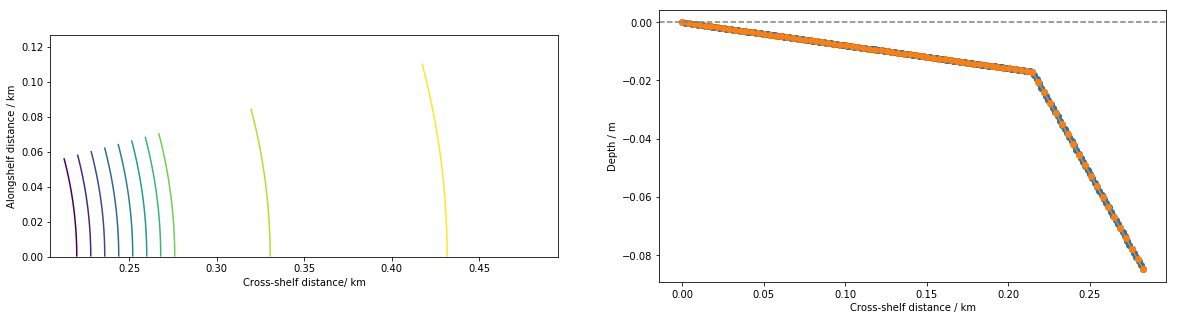

In [67]:
fig, ax = plt.subplots(1,2,figsize=(20,5))

ax[0].contour(X,Y,depth, 10)
ax[0].set_ylabel('Alongshelf distance / km')
ax[0].set_xlabel('Cross-shelf distance/ km')
ax[0].set_aspect(1)

ax[1].plot(X[0,::-1]-X[0,0],depth[0,:]-(depth[0,-1]), 'o-')
ax[1].plot(y_interp[::]-X[0,0],cs_interp, 'o-') # revert because 0 distance has to be at the coast
ax[1].axhline(0,color='0.5', linestyle='--')
ax[1].set_ylabel('Depth / m')
ax[1].set_xlabel('Cross-shelf distance / km')

### 2. Stratification ($N^2$)

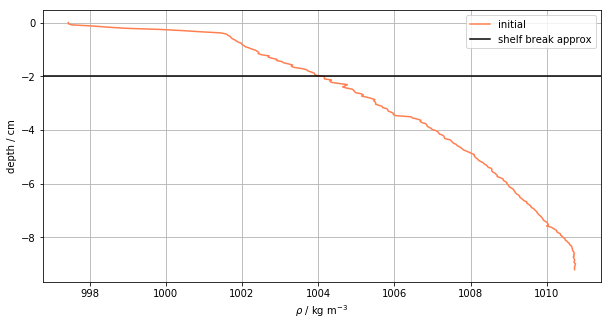

In [68]:
fig, (ax2) = plt.subplots(1,1, figsize=(10,5))
colors = ['white','tan','coral','brown']

filepath_ini = '/ocean/kramosmu/MultipleCanyons/lab/Conduino/exp_02apr19/initial_profile.mat' # Low N profile

mat_ini = sio.loadmat(filepath_ini, squeeze_me=True)

P_ini = mat_ini['ch3']
dens_P_ini = densP(mat_ini['ch3'])

time_ini = mat_ini['time']

max_depth=9.2 # cm
ind1 = np.argmax(dens_P_ini[235:470])

ax2.plot(dens_P_ini[235:235+ind1]*1000,-time2dist(max_depth,time_ini[235:235+ind1]-time_ini[135]), label='initial', color=colors[2])

#ax2.plot(dens_P_ini[696:696+ind4],-time2dist(max_depth,time_ini[696:696+ind4]-time_ini[696]),'--', label='initial 2', color=colors[2])

ax2.axhline(-2,color='k', label='shelf break approx')
ax2.legend(bbox_to_anchor=(1,1))
ax2.set_ylabel('depth / cm')
ax2.set_xlabel(r'$\rho$ / kg m$^{-3}$')
ax2.grid(axis='both')

In [69]:
RhoRef = 999.750 # density bucket 2, fresh water
Rho = dens_P_ini[235:235+ind1]*1000
dep = -time2dist(max_depth,time_ini[235:235+ind1]-time_ini[135])
dz = dep[1:]-dep[:-1]

N2 = calc_N2_lab(RhoRef,Rho[:-1],dz)


In [70]:
# Vertical levels for input and interpolation. Model requires a surface value fro N^2.

nlevs = 30
z_interp = np.linspace(np.round(np.min(dep),1),0, nlevs)
z_increment = np.round(np.mean(np.abs(z_interp[1:]-z_interp[:-1])),1)

f_int = interpolate.interp1d(dep[1:-2], N2, fill_value='extrapolate')
N2_interp = np.round(f_int(z_interp),12)


0.3


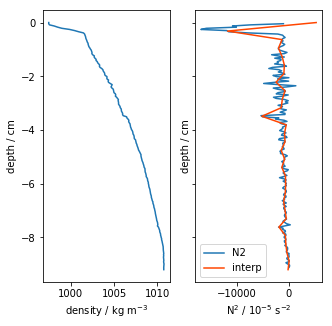

In [71]:
fig, ax = plt.subplots(1,2,figsize=(5,5), sharey=True)

ax[0].plot(Rho, dep)
ax[0].set_xlabel('density / kg m$^{-3}$')
ax[0].set_ylabel('depth / cm')

ax[1].plot(N2/1E-5, dep[1:-2], label='N2')
ax[1].plot(N2_interp/1E-5, z_interp,color='orangered', label='interp')

ax[1].set_xlabel('N$^2$ / $10^{-5}$ s$^{-2}$')
ax[1].set_ylabel('depth / cm')
print(z_increment)
ax[1].legend(loc=0)

### 3. Alongshore velocity and bottom friction

### 4. Wave length 

A possible lengthscale for this is the separation between canyon heads or half of that.

In [74]:
dist_heads = 10 # cm
k = (2*np.pi)/(dist_heads*0.5) # 1/cm

print(k)

1.2566370614359172


### 5. Wave frequency

Possible timescale is the "blocking time" and by that I mean the time it takes for the $\Delta \rho$ signal in the upstream canyon to be the same as signal for a 1 canyon run (see http://localhost:8888/notebooks/notebooks/exp_30mar19.ipynb). Although that time is longer than the upwelling forcing time.

In [76]:
block_time = 60 # sec

omega = 2*np.pi/60 #1/sec

print(omega)

0.10471975511965977


### Answers required for code initialization

In [79]:
wavenumber = k #(1/cm)
wavenumber_first = np.round(wavenumber*0.1,10)
freq_per_sec = omega
numb_freq = 200
increment = np.round(wavenumber_first*0.1,10)

f = 0.75 # rad/s  table angular velocity

In [80]:
print('How many total gridpoints do you want in the cross shelf direction? (nn)')
print(cs_points)  
print('\nHow many total gridpoints do you want in the vertical? (mm)')
print(nlevs)
print('\nFirst guess at frequency (rad/sec)? ')
print(freq_per_sec)
print('\nEnter 0 for a rigid lid, 1 for a free surface (del) ')
print(1)
print('\nEnter 0 for a closed x= 0 boundary, 1 for open (icbc) ')
print(0)
print('\nEnter 0 for a closed x =xmax boundary, 1 for an open (iobc)')
print(1)
print('\nEnter 1 for general frequency, wavenumber or 0 for long wave limit ')
print(1)
print('\nEnter the Coriolis parameter (f) (rad/sec) ')
print(f)
print('\nEnter the domain width (xmax) (km)')
width = y_interp[0]/1000
print(width)
print('\nEnter the nominal fractional accuracy for the solution (eps) ')
print(0.001)
print('\nEnter the number of frequencies to be computed (npts) ')
print(numb_freq)
print('***** tests ', 1)
print('\nEnter the first alongshore wavenumber to use (rlz) (rad/cm) ')
print(wavenumber_first)
print('\nEnter the wavenumber increment to use after rlz (drl) (rad/cm)')
print(increment)
print('\nHow many distance, depth pairs will you provide (ndep >=1)')
print(len(cs_interp)+1)  
print('\nArray of offshore distances for depth values (xdep in km) (dimension ndep)')
print(y_interp[::-1]/1000)
print('\nArray of depths corresponding to xdep (depr in m)') # positive!
print(-cs_interp)
print('\nNumber of distance, bottom friction pairs to read (nr) ')
print(2)
print('\nOffshore distances for bottom friction values (xr in km) ')
print('[0 '+str(width)+']')
print('\nArray of bottom friction values corresponding to xr (rr in cm/sec)')
print('[' + str(abs(bfr)) + ' ' + str(abs(bfr)) + '] (C_D_min * u_mean_cm)')
print('\nNumber of Nsquared values to read? (nnsq)')
print(len(N2_interp))
print('\nDepth increment for input of Nsquared values? (zr in m)')
print(z_increment)
print('\nExponential tail length for Nsquared extrapolation (alph in km')
print(2)
print('\nNsquared values starting at the surface (nsqr in rad^2/sec^2) (nnsq values)')
print(N2_interp)
print('\nInput peak value of mean alongshore flow (vzero: cm/sec)')
print(0, '(but max vel is '+str(np.round(max_vel*100,1))+')')
print('Input distance offshore to peak mean flow (km)')# 2.2
print('Input depth of peak mean flow (m)')#100
print('Downward exponential scale of mean flow? (m)')#1100
print('Upward exponential scale of mean flow? (m)')#100
print('Offshore exponential scale of mean flow? (km)')#40
print('Onshore exponential scale of mean flow? (km)')#100
print('Enter 1 for undisturbed Nsquared offshore, 0 for onshore 1')


How many total gridpoints do you want in the cross shelf direction? (nn)
80

How many total gridpoints do you want in the vertical? (mm)
30

First guess at frequency (rad/sec)? 
0.10471975511965977

Enter 0 for a rigid lid, 1 for a free surface (del) 
1

Enter 0 for a closed x= 0 boundary, 1 for open (icbc) 
0

Enter 0 for a closed x =xmax boundary, 1 for an open (iobc)
1

Enter 1 for general frequency, wavenumber or 0 for long wave limit 
1

Enter the Coriolis parameter (f) (rad/sec) 
0.75

Enter the domain width (xmax) (km)
0.00021200000000000003

Enter the nominal fractional accuracy for the solution (eps) 
0.001

Enter the number of frequencies to be computed (npts) 
200
***** tests  1

Enter the first alongshore wavenumber to use (rlz) (rad/cm) 
0.1256637061

Enter the wavenumber increment to use after rlz (drl) (rad/cm)
0.0125663706

How many distance, depth pairs will you provide (ndep >=1)
81

Array of offshore distances for depth values (xdep in km) (dimension ndep)
[0.000495 

NameError: name 'bfr' is not defined

#### Frequency assuming standing waves

In [ ]:
kv = (2*np.pi/(50E5))
U = 30 # cm/s

omega_v = U*kv
print(omega_v)

In [ ]:
kw = k/100
U = 30 # cm/s

omega_w = U*kw
print(omega_w)

In [ ]:
(2*3.14)/15